In [132]:
!pip install wget
import pandas as pd
import wget
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [133]:
url =  'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [134]:
downloaded_file = wget.download(url)

100% [...........................................................] 80876 / 80876

In [135]:
df = pd.read_csv(downloaded_file)

In [136]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [137]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [138]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [139]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

In [140]:
categorical_columns

['lead_source', 'industry', 'employment_status', 'location']

In [141]:
for c in categorical_columns:
    df[c] = df[c].fillna('NA')

In [142]:
numerical_columns = list(df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index)

In [143]:
numerical_columns

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [144]:
for n in numerical_columns:
    df[n] = df[n].fillna(0.0)

In [145]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [146]:
from sklearn.model_selection import train_test_split

In [147]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)

In [148]:
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [149]:
df_train = df_train.reset_index(drop = True)

In [150]:
df_val = df_val.reset_index(drop = True)

In [151]:
df_test = df_test.reset_index(drop = True)

In [152]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [153]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

Question 1: ROC AUC feature importance

In [154]:
numerical_columns = ['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [155]:
numerical_columns

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [156]:
from sklearn.metrics import roc_auc_score

In [157]:
for n in numerical_columns:
    score = roc_auc_score(y_train, df_train[n])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[n])
    print('%9s, %.3f' % (n, score))

number_of_courses_viewed, 0.764
annual_income, 0.552
interaction_count, 0.738
lead_score, 0.614


number_of_courses_viewed has the highest AUC

Question 2: Training the model

In [158]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [159]:
def train(df, y):
    dicts = df[numerical_columns + categorical_columns].to_dict(orient = 'records')
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train,y)
    return dv, model

In [160]:
def predict (df, dv, model):
    dicts = df[numerical_columns + categorical_columns].to_dict(orient = 'records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [161]:
dv, model = train(df_train, y_train)

In [162]:
y_pred = predict(df_val, dv, model)

In [163]:
auc = roc_auc_score(y_val, y_pred)

In [164]:
round(auc, 3)

0.817

0.72 is close enough. Don't think the model will have AUC over 0.9

Question 3: Precision and Recall

In [165]:
columns = ['threshold', 'tp', 'tn', 'fp', 'fn']

In [166]:
scores = []

In [167]:
for t in np.arange(0, 1, 0.01):
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    #precision = tp/(tp+fp)
    #recall = tp/(tp+fn)
    scores.append((t, tp, tn, fp, fn))

In [168]:
scores

[(np.float64(0.0), np.int64(171), np.int64(0), np.int64(122), np.int64(0)),
 (np.float64(0.01), np.int64(171), np.int64(0), np.int64(122), np.int64(0)),
 (np.float64(0.02), np.int64(171), np.int64(0), np.int64(122), np.int64(0)),
 (np.float64(0.03), np.int64(171), np.int64(0), np.int64(122), np.int64(0)),
 (np.float64(0.04), np.int64(171), np.int64(0), np.int64(122), np.int64(0)),
 (np.float64(0.05), np.int64(171), np.int64(0), np.int64(122), np.int64(0)),
 (np.float64(0.06), np.int64(171), np.int64(0), np.int64(122), np.int64(0)),
 (np.float64(0.07), np.int64(171), np.int64(0), np.int64(122), np.int64(0)),
 (np.float64(0.08), np.int64(171), np.int64(0), np.int64(122), np.int64(0)),
 (np.float64(0.09), np.int64(171), np.int64(0), np.int64(122), np.int64(0)),
 (np.float64(0.1), np.int64(171), np.int64(0), np.int64(122), np.int64(0)),
 (np.float64(0.11), np.int64(171), np.int64(0), np.int64(122), np.int64(0)),
 (np.float64(0.12), np.int64(171), np.int64(0), np.int64(122), np.int64(0)),
 

In [169]:
df_scores = pd.DataFrame(scores, columns = ['threshold', 'tp', 'tn', 'fp', 'fn'])

In [170]:
df_scores

,threshold,tp,tn,fp,fn
0,0.00,171,0,122,0
1,0.01,171,0,122,0
2,0.02,171,0,122,0
3,0.03,171,0,122,0
4,0.04,171,0,122,0
...,...,...,...,...,...
95,0.95,5,122,0,166
96,0.96,3,122,0,168
97,0.97,1,122,0,170
98,0.98,0,122,0,171


In [171]:
df_scores['precision'] = df_scores.tp/(df_scores.tp + df_scores.fp)

In [172]:
df_scores['recall'] = df_scores.tp/(df_scores.tp + df_scores.fn)

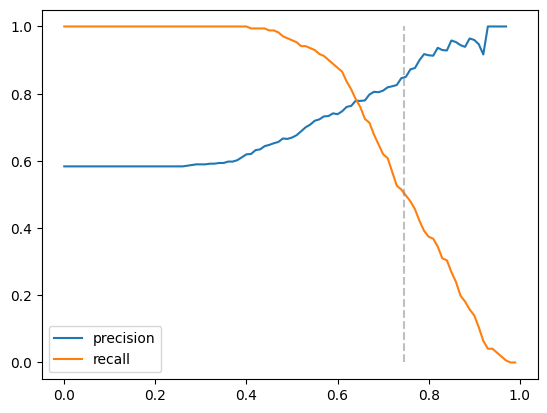

In [176]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.vlines(0.745, 0, 1, color='grey', linestyle='--', alpha=0.5)
plt.legend()

At 0.745 threshold precision and recall curves intersect

Question 4: F1 score

In [177]:
df_scores['F1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

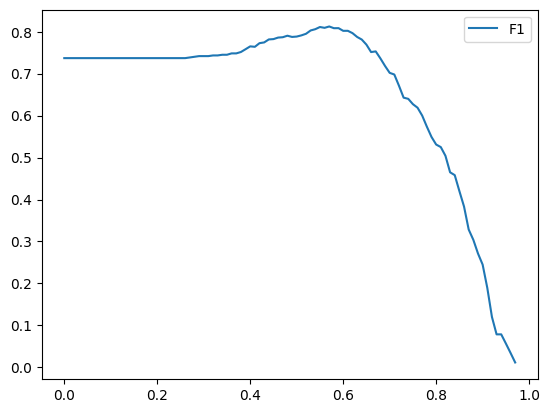

In [178]:
plt.plot(df_scores.threshold, df_scores['F1'], label='F1')
plt.legend()

At 0.54 threshold F1 is maximal

Question 5: 5-Fold CV

In [179]:
from sklearn.model_selection import KFold

In [180]:
scores = []

In [181]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [182]:
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    del df_train['converted']
    del df_val['converted']

    dv, model = train (df_train, y_train)
    y_pred = predict (df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)

    scores.append(auc)

In [183]:
scores

[0.8060745924216483,
 0.8713738368910783,
 0.7754320118852139,
 0.8018368617683685,
 0.8558272713202291]

In [189]:
print('%.2f'% np.std(scores))

0.04


0.06 is the closest standard deviation

Question 6: Hyperparameter Tuning

In [213]:
def train(df, y, C):
    dicts = df[numerical_columns + categorical_columns].to_dict(orient = 'records')
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train,y)
    return dv, model

In [214]:
scores = []

In [218]:
for C in [0.000001, 0.001, 1]:
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values
    
        del df_train['converted']
        del df_val['converted']
    
        dv, model = train (df_train, y_train, C=C)
        y_pred = predict (df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append(auc)
    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06, 0.723 +- 0.145
C=0.001, 0.741 +- 0.144
C=   1, 0.750 +- 0.139


C = 1 leads to the best mean score